# Neural Network from Scratch

Although you'd never do this on a real problem, it makes sense to implement a Neural Network from scratch and apply it to a simple problem since it gives you an idea of how the algorithm works.

The goal with the code below is to aid understanding. It's not a very efficient solution at all.

## Modules

In [162]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
import random
import urllib
import gzip

import matplotlib
#
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

## Create Data

Create data for a simple binary classification problem.

In [278]:
DATADIR = "/Users/Simran/Desktop"

In [279]:
IMAGEW = 28
IMAGEH = 28
LABELS = 10

In [280]:
def cached_download(filename):
    """
    Only download data files if necessary.
    """
    try:
        os.stat(DATADIR)
    except:
        os.mkdir(DATADIR)
    #
    filepath = os.path.join(DATADIR, filename)
    #
    if not os.path.isfile(filepath):
        filepath, headers = urllib.request.urlretrieve(URLBASE + filename, filepath)
    #
    return filepath

In [281]:
URLBASE = 'http://yann.lecun.com/exdb/mnist/'
images_pathname = cached_download('train-images-idx3-ubyte.gz')
labels_pathname = cached_download('train-labels-idx1-ubyte.gz')
images, labels = unpack_files(images_pathname, labels_pathname, 60000)

In [282]:
def unpack_files(imagefile, labelsfile, count):
    with gzip.open(imagefile) as f:
        f.read(16)
        buf = f.read(IMAGEW * IMAGEH * count)
        images = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
        images = images.reshape(count, IMAGEW, IMAGEH)
    with gzip.open(labelsfile) as f:
        f.read(8)
        labels = np.frombuffer(f.read(1 * count), dtype = np.uint8).astype(np.int64)
    
    return (images, labels)

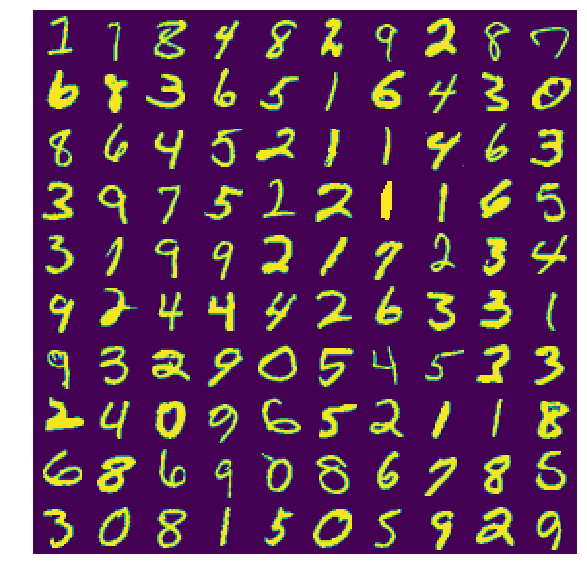

In [283]:
imgmatrix = np.vstack([np.hstack([images[random.randrange(len(labels)),:,:] for i in range(10)]) for j in range(10)])
plt.imshow(imgmatrix, interpolation = 'nearest')
plt.axis('off')
plt.show()

In [284]:
images = images.reshape(len(labels), -1)
images.shape

(60000, 784)

In [285]:
N = images.shape[0]

# Set random seed so that we get repeatable data.
#
np.random.seed(0)

# Generate data.
#
# -> Concentric circles.
#
# X, y = sklearn.datasets.make_circles(N, noise = 0.05, factor = 0.5)
#
# -> Interleaved half-circles.
#
# X, y = sklearn.datasets.make_moons(N, noise = 0.20)

## Model Parameters

We'll build a Neural Network with an input layer, one hidden layer and an output layer.

In [286]:
# Dimensions of input and output layers.

idim = 784
odim = 10

# idim = 2
# odim = 2

# Learning rate.
#
epsilon = 0.01

# Regularisation.
#
LAMBDA = 0.01

## Model

We'll use the [tanh](http://reference.wolfram.com/language/ref/Tanh.html) activation function. This is a convenient choice since it has a simple derivative.

In [300]:
def soft_max(scores):
    """
    Convert scores to probabilities.
    """
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)

def predict(model, x):
    """
    Generate a prediction via forward propagation.
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    # Input values to hidden layer.
    z1 = x.dot(W1) + b1
    # Activation of hidden layer.
    a1 = np.tanh(z1)
    # Input to ouput layer.
    z2 = a1.dot(W2) + b2
    
    return soft_max(z2)

def predict_class(model, x):
    return np.argmax(predict(model, x), axis = 1)

In [308]:
def loss(model, x, y):
    """
    Evaluate cross-entropy loss.
    """
    W1, W2 = model['W1'], model['W2']
    #
    probs = predict(model, x)
    #
    L = np.sum(-np.log(probs[range(y.shape[0]), y]))
    # Add regularization.
    L += LAMBDA / 2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    #
    return L / N

In [304]:
def build_model(hdim, passes = 20000, verbose = False):
    """
    Train model using backward propagation and batch gradient descent.
    
    :param hdim: Number of hidden nodes.
    :param passes: Number of iterations.
    :param verbose: Whether or not to produce status information.
    :return: data frame.
    """
    np.random.seed(0)
    #
    # Initialise the weights and biases.
    #
    W1 = np.random.randn(idim, hdim) / np.sqrt(idim)
    b1 = np.zeros((1, hdim))
    W2 = np.random.randn(hdim, odim) / np.sqrt(hdim)
    b2 = np.zeros((1, odim))
    #
    # W1 is a (idim, hdim) array
    # b1 is a (1, hdim) array
    # W2 is a (hdim, odim) array
    # b2 is a (1, odim) array
    #
    # X is a (N, idim) array
    # y is a (N, 1) array
    batch_size = 1000
    for i in range(0, passes):
        index = random.sample(range(len(labels)), batch_size)
        X = images[index]
        y = labels[index]
        # Generate predictions with current model via forward propagation.
        #
        # (N, idim) x (idim, hdim) -> (N, hdim)
        #
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        #
        # z1 is input to the hidden layer.
        # a1 is output from the hidden layer (after applying the activation function).
        #
        # (N, hdim) x (hdim, odim) -> (N, odim)
        #
        z2 = a1.dot(W2) + b2
        #
        # z2 is input to the output layer.
        #
        delta = soft_max(z2)
        #
        # delta is a (   N, odim) array

        # Backward propagation.
        #
        # Takes advantage of d/dx tanh(x) = 1 - tanh(x)^2.
        #
        delta[range(batch_size), y] -= 1
        #
        # (idim, N) x (N, odim) -> (idim, odim)
        #
        dW2 = (a1.T).dot(delta)
        db2 = np.sum(delta, axis = 0, keepdims = True)
        delta2 = delta.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Update model parameters, including regularisation.
        #
        W1 += -epsilon * (dW1 + LAMBDA * W1)
        b1 += -epsilon * db1
        W2 += -epsilon * (dW2 + LAMBDA * W2)
        b2 += -epsilon * db2
        
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        if verbose and i % 1000 == 0:
          print("iteration %i: Loss = %f" %(i, loss(model, X, y)))
    
    return model

In [292]:
def plot_decision_boundary(model):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    # Make predictions over a grid.
    dx, dy = 0.01, 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dx), np.arange(y_min, y_max, dy))
    Z = predict_class(model, np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    #
    plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.Spectral)

## Build a Reasonable Model

By trial and error it was found that a hidden layer with 3 nodes produced a reasonable model.

In [309]:
model = build_model(3, verbose = True)

iteration 0: Loss = 0.041389
iteration 1000: Loss = 0.053389
iteration 2000: Loss = 0.072568
iteration 3000: Loss = 0.104495
iteration 4000: Loss = 0.105748
iteration 5000: Loss = 0.095905
iteration 6000: Loss = 0.093559
iteration 7000: Loss = 0.095047
iteration 8000: Loss = 0.089230
iteration 9000: Loss = 0.075633
iteration 10000: Loss = 0.079317
iteration 11000: Loss = 0.053322
iteration 12000: Loss = 0.067528
iteration 13000: Loss = 0.106039
iteration 14000: Loss = 0.067308
iteration 15000: Loss = 0.060807
iteration 16000: Loss = 0.064801
iteration 17000: Loss = 0.068889
iteration 18000: Loss = 0.057176
iteration 19000: Loss = 0.064515


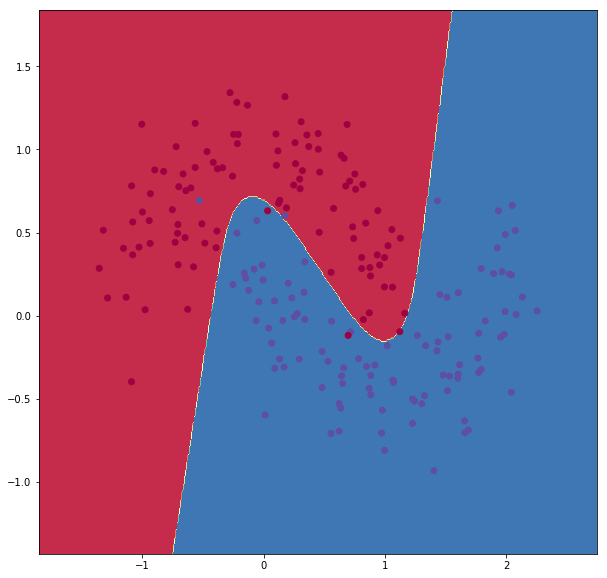

In [14]:
plot_decision_boundary(model)

## Other Model Configurations

Let's explore some simpler and more complicated models. It's clear that 1 or 2 hidden nodes is insufficient. Nothing seems to be gained from having more than 3 nodes. However, more nodes in the hidden layer mean that the model takes longer to train and that it is more prone to overfitting.

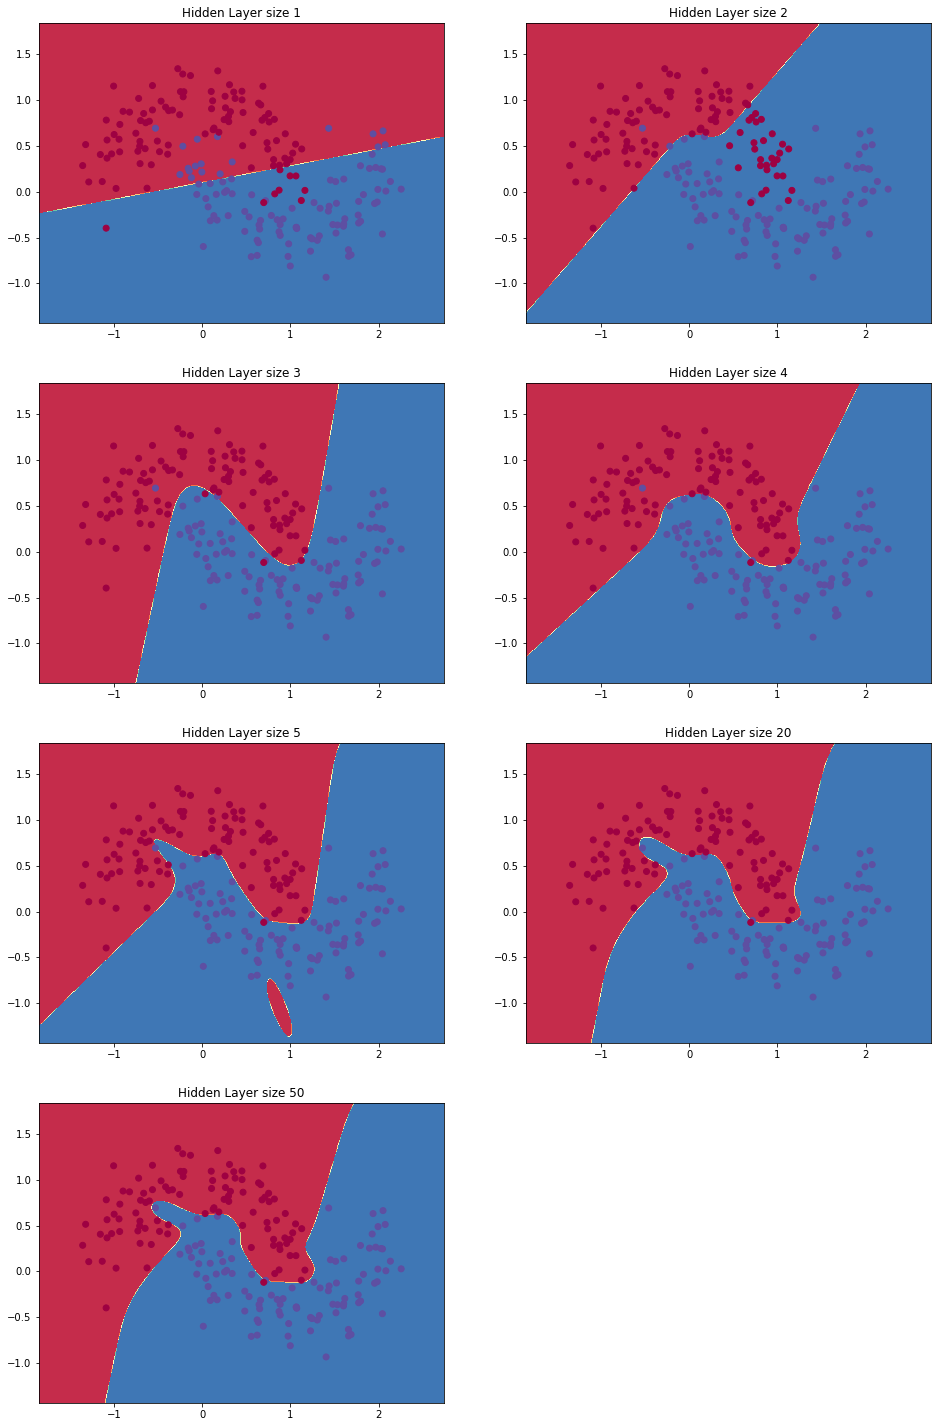

In [15]:
plt.figure(figsize=(16, 32))

for i, hdim in enumerate([1, 2, 3, 4, 5, 20, 50]):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hdim)
    plot_decision_boundary(build_model(hdim))

plt.show()

## Exercises

1. Build the alternative data set (see commented code) and repeat the analysis. Find the optimal number of hidden nodes.
2. Figure out what's happening in the backward propagation code.
3. Adapt this code to handle the MNIST data.
    - Does the loss function still work for a multi-class problem?
    - Do you need more hidden nodes? Estimate an appropriate number.
4. Add ability to continue model build with existing weights (restart model training).
5. Adapt the algorithm from batch descent to mini-batch descent.
6. Try using a sigmoidal activation function (see example implementation below).
7. Allow the learning rate to decay as the model converges. For example, scale with `sqrt(epoch)`.
8. Evaluate the training accuracy. Using the MNIST testing data to objectively assess accuracy.

In [16]:
def logistic(x, derivative = False):
    if derivative:
        x = logistic(x)
        return x * (1 - x)
    return 1 / (1 + np.exp(-x))

In [32]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [33]:
images = train.iloc[:,1:].values
images = np.divide(images, 255.0)

In [34]:
labels = train['label'].values.ravel()

In [8]:
label_count = labels.shape[0]
labels_one_hot = np.eye(label_count, 10, dtype=int)[labels]

In [133]:
X = images
y = labels

In [112]:
print(x.shape)

(42000, 784)


In [134]:
N = (y.shape[0])

In [35]:
train_size = 33000
x_train = images[train_size:]
y_train = labels_one_hot[:train_size]
x_test = images[train_size:]
y_test = labels_one_hot[:train_size]